In [1]:
import os

import numpy as np
import pandas as pd
import scipy.stats as sts

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

import lib.exp4 as exp4
from lib.reconstruction.config import colors, set_library_options
import lib.reconstruction.errors as errs
import lib.reconstruction.features as ftrs
import lib.reconstruction.neighbors as nbrs
from lib.reconstruction.permutation_tests import PermuationTestBetween, PermutationTestWithin

import lib.utility_functions as uf
import lib.util.datatype_utilities as dtutils

# Config
set_library_options()

% matplotlib inline

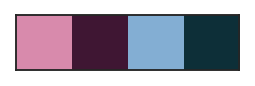

In [2]:
sns.palplot(colors.values())

In [4]:
tidy = pd.read_csv('./tidy_data.csv', index_col=0)
tidy['Condition'] = tidy['Condition'].map(lambda x: 'Untrained' if x == 'Naive' else x)
tidy['Position ID'] = tidy['Position ID'].map(int)

vals = ['Black Position', 'White Position', 'Is Real', 'Num Pieces']

board_set = tidy.pivot_table(index='Position ID', values=vals, aggfunc=lambda x: x.unique()[0])[vals]

In [37]:
tidy['Type I Rate'] = tidy['Type I Errors'] / (36 - tidy['Num Pieces'])
tidy['Type II Rate'] = tidy['Type II Errors'] / tidy['Num Pieces']
tidy['Type III Rate'] = tidy['Type III Errors'] / tidy['Num Pieces']

/Users/gianni/anaconda/lib/python3.5/site-packages/matplotlib/legend.py:651: UserWarning: Automatic legend placement (loc="best") not implemented for figure legend. Falling back on "upper right".
  warnings.warn('Automatic legend placement (loc="best") not '


Real positions p: 0.795 val: 0.0029948482534144297
Fake positions p: 0.669 val: 0.007088493802144019


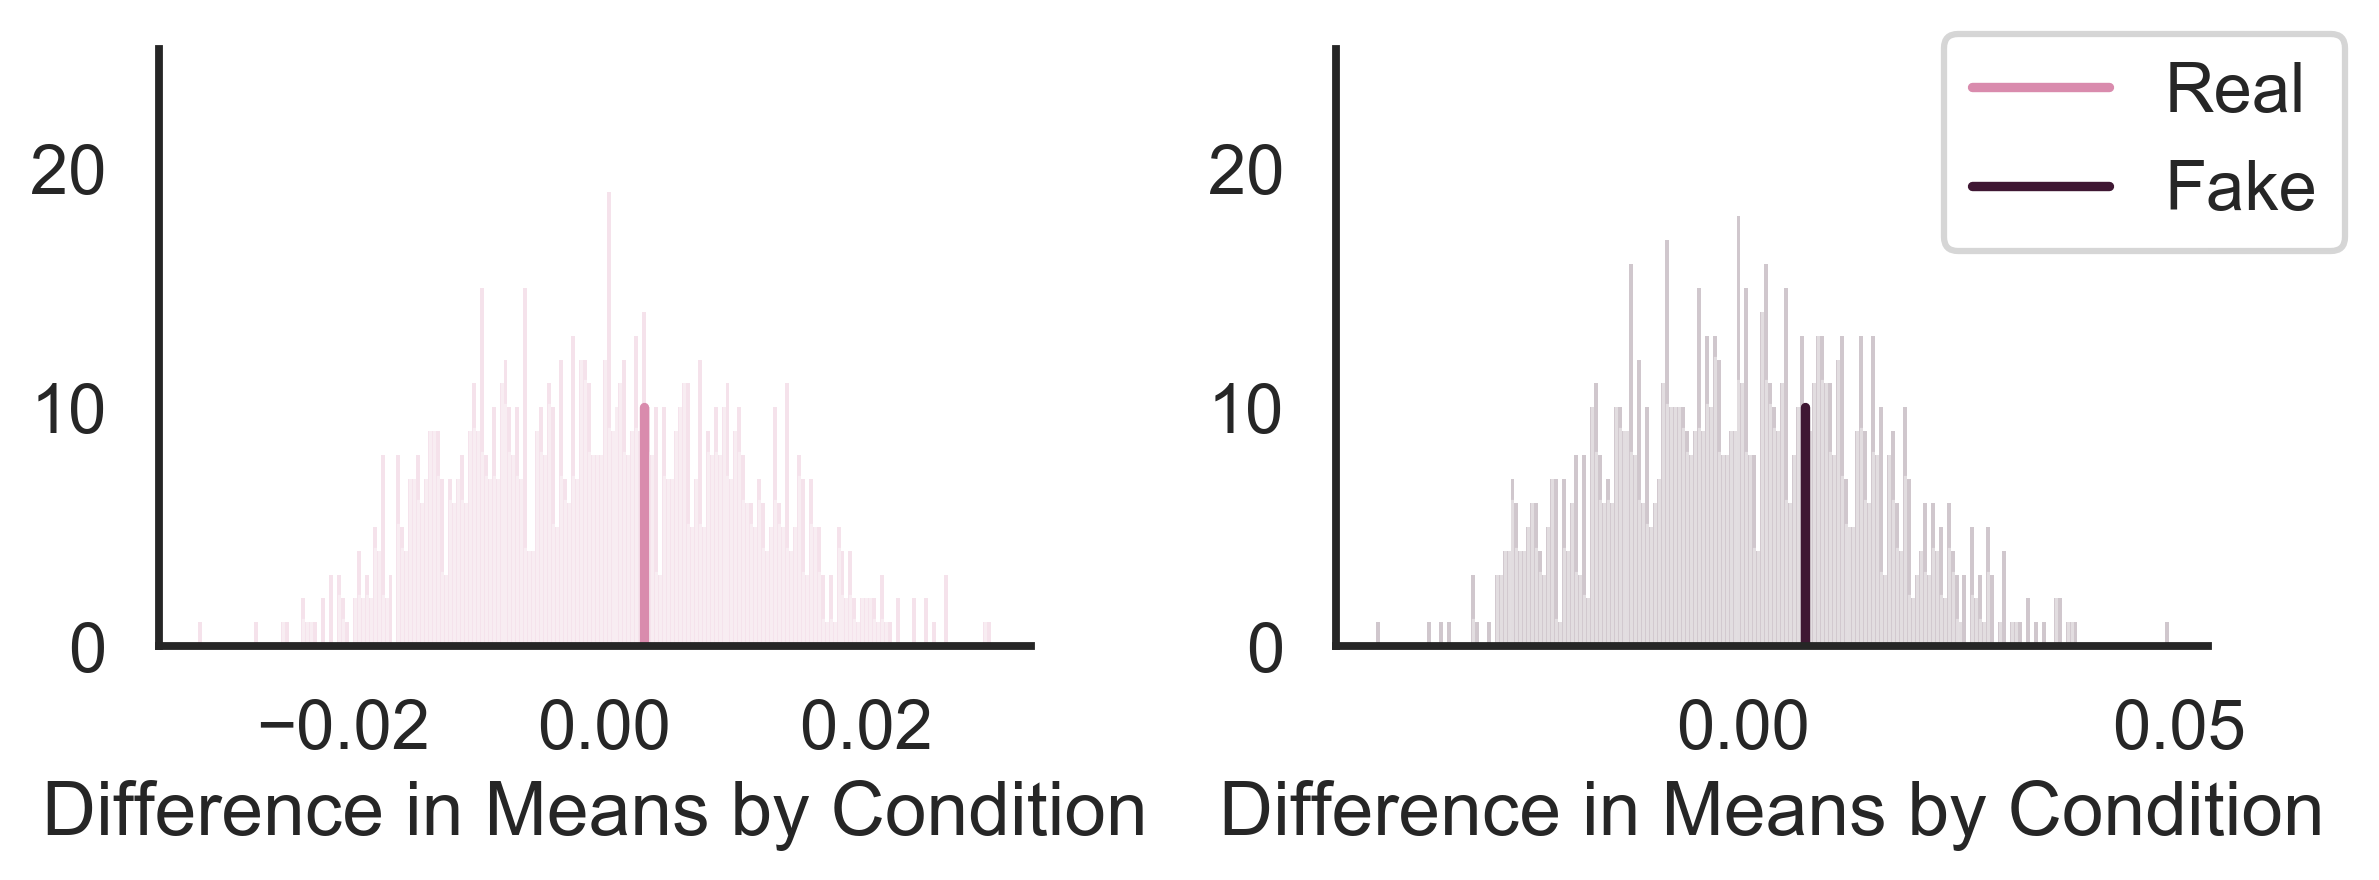

In [38]:
between_permutation_test = PermuationTestBetween(tidy)
    
samples, axes = between_permutation_test('Type I Rate')

In [ ]:
within_permuation_test = PermutationTestWithin(tidy)

samples, axes = within_permutation_test('Type I Rate')

/Users/gianni/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/gianni/anaconda/lib/python3.5/site-packages/matplotlib/legend.py:652: UserWarning: Automatic legend placement (loc="best") not implemented for figure legend. Falling back on "upper right".
  warnings.warn('Automatic legend placement (loc="best") not '


Real positions p: 0.3487 val: -0.4002192982456141
Fake positions p: 0.1817 val: -0.6929824561403501


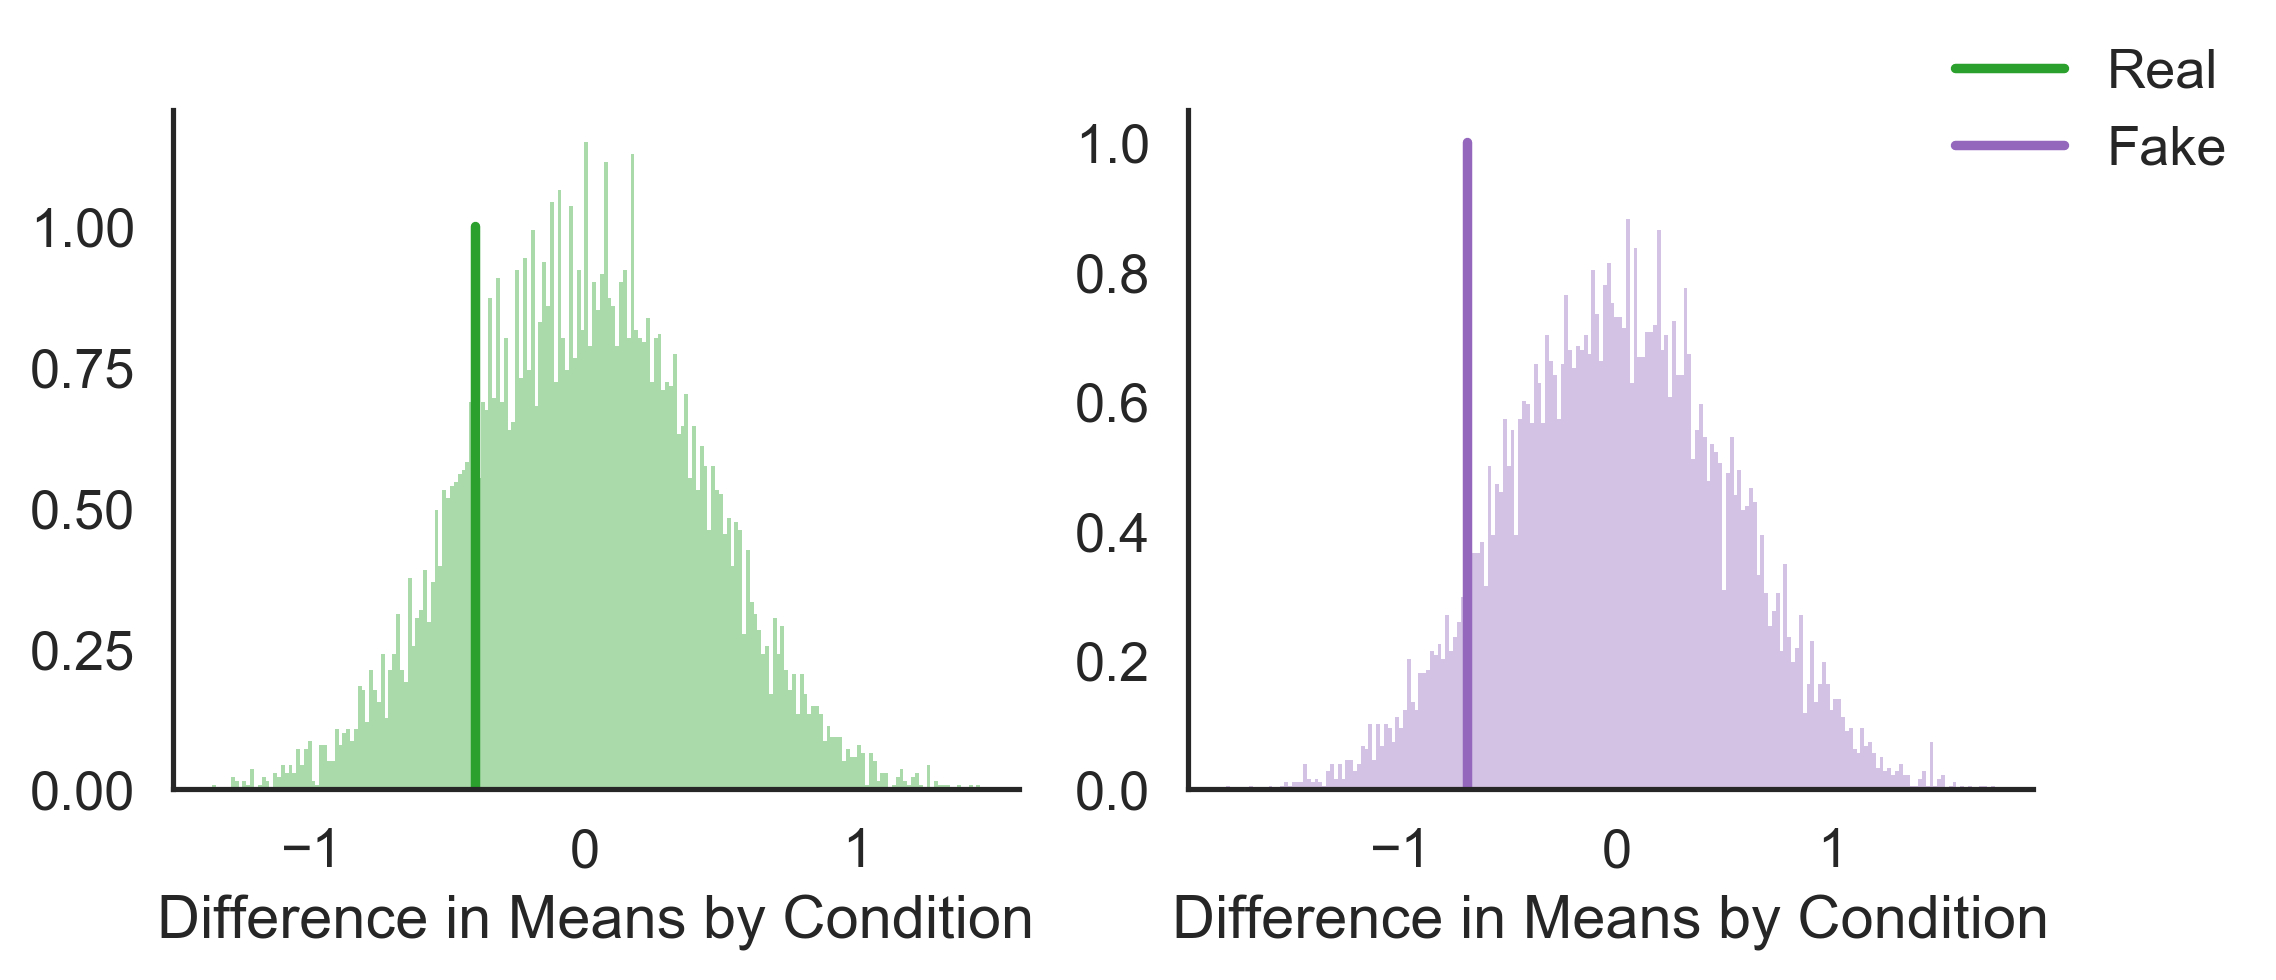

In [10]:
samples, axes = between_permutation_test('Num Dif')

In [39]:
def within_permutation_test(target_var, num_resamples=10000):
    
    g = tidy.groupby('Subject ID', sort=False)
    
    def get_piv():
        piv = tidy.pivot_table(
            index='Subject ID', values=target_var,
            columns='Resampled Is Real',
            aggfunc=np.mean
        )

        piv['Condition'] = piv.index.map(lambda x: tidy.loc[tidy['Subject ID'] == x, 'Condition'].values[0])
        
        return piv
    
    def resample_from_groups(df):
        return df[['Is Real', 'Subject ID']].sample(frac=1, replace=False)
        
    def shuffle_real():
        applied = g.apply(resample_from_groups)
        applied = pd.DataFrame(applied)
        melted = pd.melt(applied, id_vars=['Subject ID'], value_vars=['Is Real'], value_name='Is Real')
        
        return melted['Is Real'].values
    
    piv = tidy.pivot_table(
        index='Subject ID', values=target_var,
        columns='Is Real',
        aggfunc=np.mean
    )

    piv['Condition'] = piv.index.map(lambda x: tidy.loc[tidy['Subject ID'] == x, 'Condition'].values[0])

    condition_filter = piv['Condition'] == 'Trained'
    
    true_trained_dif = piv.loc[condition_filter, True].mean() - piv.loc[condition_filter, False].mean()
    true_untrained_dif = piv.loc[~condition_filter, True].mean() - piv.loc[~condition_filter, False].mean()
    
    samples = {'trained': [], 'untrained': []}
    
    for i in range(num_resamples):
        tidy['Resampled Is Real'] = shuffle_real()
        
        piv = get_piv()
        
        condition_filter = piv['Condition'] == 'Trained'
        
        trained_dif = piv.loc[condition_filter, True].mean() - piv.loc[condition_filter, False].mean()
        untrained_dif = piv.loc[~condition_filter, True].mean() - piv.loc[~condition_filter, False].mean()
    
        samples['trained'].append(trained_dif)
        samples['untrained'].append(untrained_dif)
        
    # Break out plotting and prints to separate function
    fig, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=300)
    
    sns.distplot(samples['trained'], bins=200, color=colors['trained'], kde=False, norm_hist=True, ax=axes[0])
    sns.distplot(samples['untrained'], bins=200, color=colors['untrained'], kde=False, norm_hist=True, ax=axes[1])

    axes[0].plot([true_trained_dif, ]*2, [0, 3], color=colors['trained'], label='Trained')
    axes[1].plot([true_untrained_dif, ]*2, [0, 3], color=colors['untrained'], label='Untrained')

    plt.figlegend(loc=0)
    plt.setp(axes, xlabel='Difference in Means by Position Type')

    sns.despine()
    
    trained = np.stack(samples['trained'])
    trained_index = (trained >= np.abs(true_trained_dif))
    trained_index |= (trained <= -np.abs(true_trained_dif))

    print('Trained subjects p:', len(trained[trained_index]) / len(trained), 'val:', true_trained_dif)

    untrained = np.stack(samples['untrained'])
    untrained_index = (untrained >= np.abs(true_untrained_dif))
    untrained_index |= (untrained <= -np.abs(true_untrained_dif))

    print('Untrained subjects p:', len(untrained[untrained_index]) / len(untrained), 'val:', true_untrained_dif)
    
    return samples, axes

In [ ]:
samples, axes = within_permutation_test('Type III Rate')

/Users/gianni/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/gianni/anaconda/lib/python3.5/site-packages/matplotlib/legend.py:652: UserWarning: Automatic legend placement (loc="best") not implemented for figure legend. Falling back on "upper right".
  warnings.warn('Automatic legend placement (loc="best") not '


Trained subjects p: 0.0 val: -0.45614035087719285
Untrained subjects p: 0.0 val: -0.7489035087719289


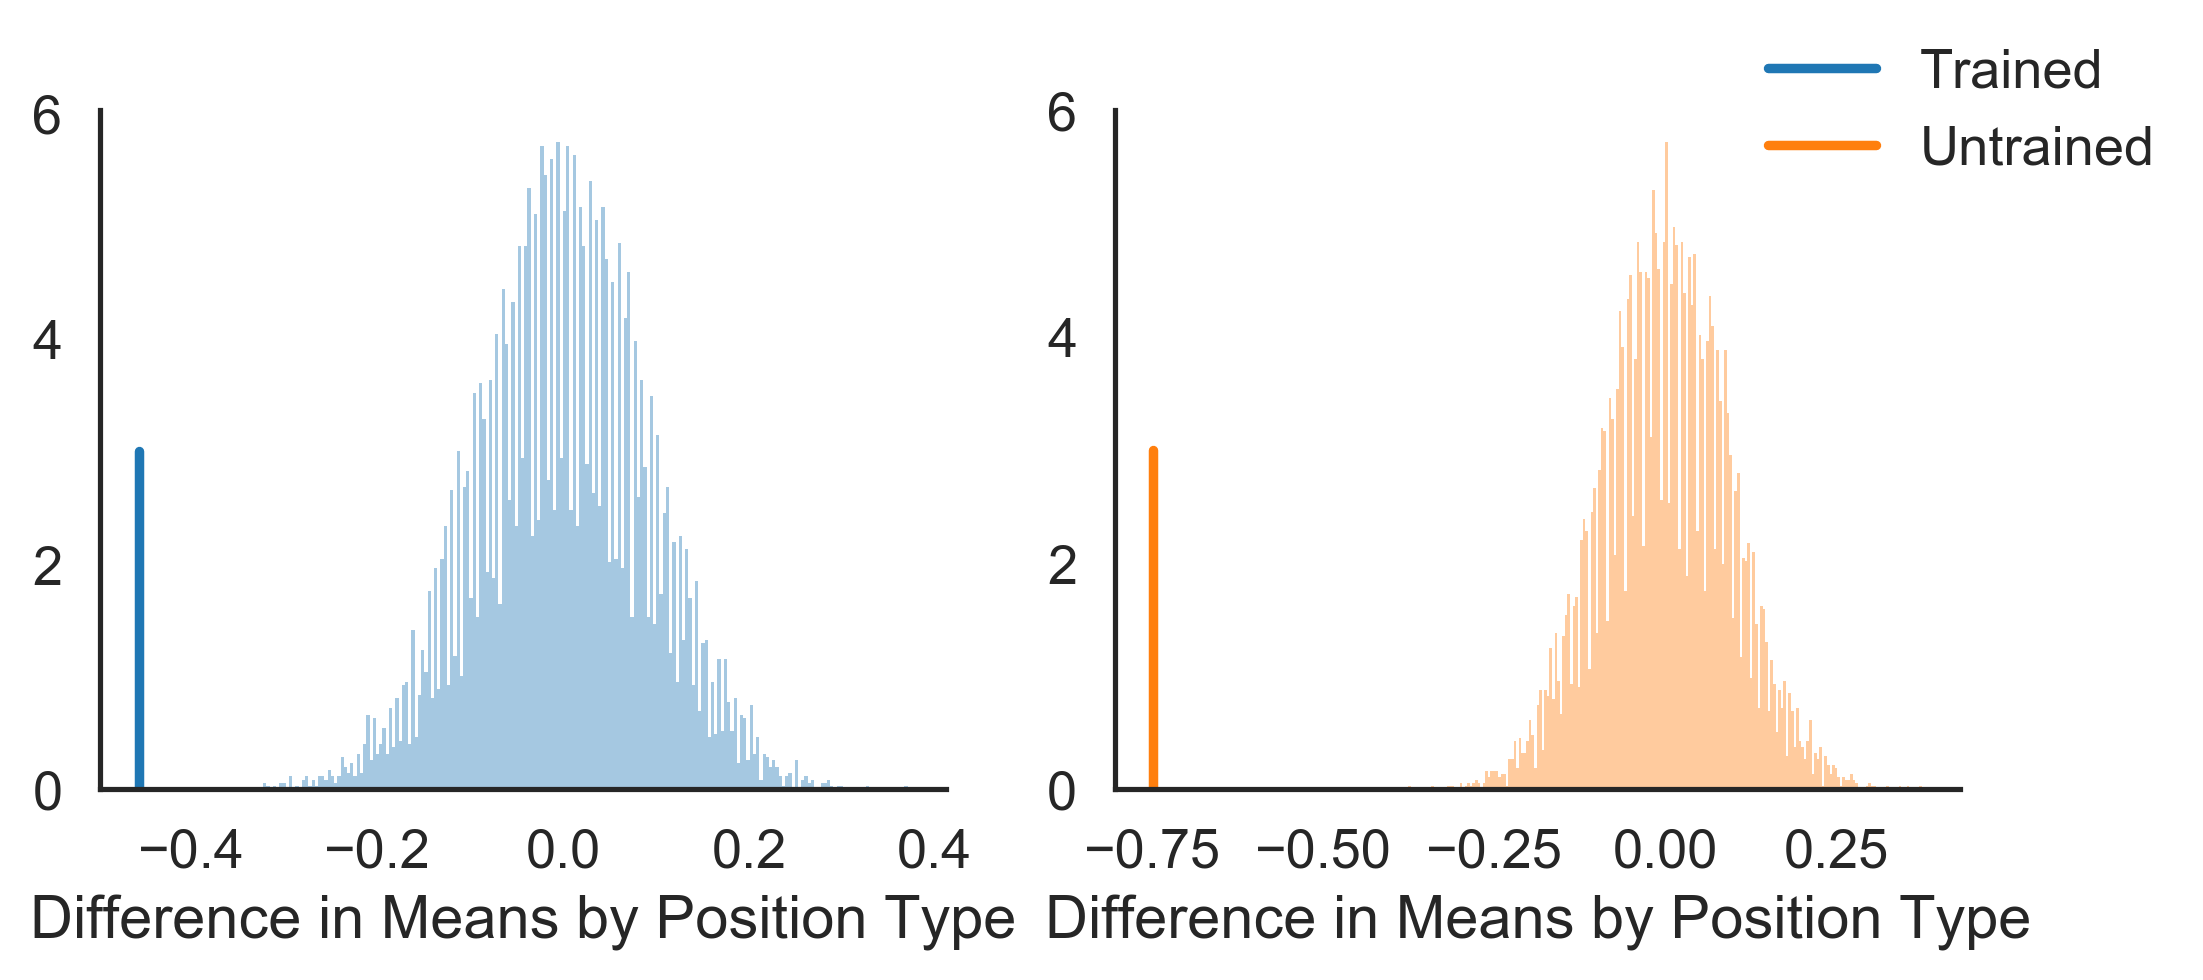

In [13]:
samples, axes = within_permutation_test('Num Dif')

In [ ]:
cpiv = tidy.pivot_table(
    index='Subject ID', values='Total Errors',
    columns='Is Real',
    aggfunc=np.mean
)

cpiv['Condition'] = cpiv.index.map(lambda x: tidy.loc[tidy['Subject ID'] == x, 'Condition'].values[0])

cpiv_filter = cpiv['Condition'] == 'Trained'
true_real_dif_x_group = cpiv.loc[cpiv_filter, True].mean() - cpiv.loc[~cpiv_filter, True].mean()
true_fake_dif_x_group = cpiv.loc[cpiv_filter, False].mean() - cpiv.loc[~cpiv_filter, False].mean()

true_trained_dif_x_type = cpiv.loc[cpiv_filter, True].mean() - cpiv.loc[cpiv_filter, False].mean()
true_untrained_dif_x_type = cpiv.loc[~cpiv_filter, True].mean() - cpiv.loc[~cpiv_filter, False].mean()

In [ ]:
resampled_trained = []
resampled_naive = []

g = tidy.groupby('Subject ID', sort=False)

for i in range(n_resamples):
    tidy['Is Real_R'] = pd.melt(
        pd.DataFrame(g.apply(lambda x: x[['Is Real', 'Subject ID']].sample(frac=1, replace=False))),
        id_vars=['Subject ID'], value_vars=['Is Real'], value_name='Is Real'
    )['Is Real'].values

    is_trained = tidy['Condition'] == 'Trained'
    is_real = tidy['Is Real_R']
    
    trained_dif = tidy.loc[is_trained & is_real, 'Total Errors'].mean() - tidy.loc[is_trained & ~is_real, 'Total Errors'].mean()
    naive_dif = tidy.loc[~is_trained & is_real, 'Total Errors'].mean() - tidy.loc[~is_trained & ~is_real, 'Total Errors'].mean()

    resampled_trained.append(trained_dif)
    resampled_naive.append(naive_dif)

sns.distplot(resampled_trained, bins=200, norm_hist=True)
sns.distplot(resampled_naive, bins=200, norm_hist=True)

plt.plot([original_trained_dif, original_trained_dif], [0, 2.5])
plt.plot([original_naive_dif, original_naive_dif], [0, 2.5])

sns.despine()

resampled_trained = np.stack(resampled_trained)
true_loc = (resampled_trained >= np.abs(original_trained_dif))
true_loc |= (resampled_trained <= -np.abs(original_trained_dif))

len(resampled_trained[true_loc]) / len(resampled_trained)

In [ ]:
cpiv

In [ ]:
print(true_fake_dif_x_group, true_real_dif_x_group)

In [ ]:
print(true_trained_dif_x_type, true_untrained_dif_x_type)

In [ ]:
# Is there a significant difference between conditions?

num_resamples = 10000

resampled_real = []
resampled_fake = []

for i in range(num_resamples):
    
    cpiv['cr'] = cpiv['Condition'].sample(frac=1, replace=False).values
    cpiv_filter = cpiv['cr'] == 'Trained'
    
    real_dif_x_group = cpiv.loc[cpiv_filter, True].mean() - cpiv.loc[~cpiv_filter, True].mean()
    fake_dif_x_group = cpiv.loc[cpiv_filter, False].mean() - cpiv.loc[~cpiv_filter, False].mean()
    
    resampled_real.append(real_dif_x_group)
    resampled_fake.append(fake_dif_x_group)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=300)
sns.distplot(resampled_real, color=colors[0], bins=200, kde=False, norm_hist=True, ax=axes[0])
sns.distplot(resampled_fake, bins=200, color=colors[1], kde=False, norm_hist=True, ax=axes[1])

axes[0].plot([true_real_dif_x_group, ]*2, [0, 1], color=colors[0], label='Real')
axes[1].plot([true_fake_dif_x_group, ]*2, [0, 1], color=colors[1], label='Fake')

plt.figlegend(loc=0)
plt.setp(axes, xlabel='Condition Mean Difference')

sns.despine()

In [ ]:
resampled_real = np.stack(resampled_real)
real_loc = (resampled_real >= np.abs(true_real_dif_x_group))
real_loc |= (resampled_real <= -np.abs(true_real_dif_x_group))

print('Real positions p:', len(resampled_real[real_loc]) / len(resampled_real))

resampled_fake = np.stack(resampled_fake)
fake_loc = (resampled_fake >= np.abs(true_fake_dif_x_group))
fake_loc |= (resampled_fake <= -np.abs(true_fake_dif_x_group))

print('Fake positions p:', len(resampled_fake[fake_loc]) / len(resampled_fake))


In [ ]:
position_map = tidy.pivot_table(
    index='Position ID', values='Is Real', aggfunc=lambda x: x.values[0]
)

# check to make sure position IDs cannot be reassigned to a position that might exist in both types
position_map['Resampled'] = position_map['Is Real'].sample(frac=1, replace=False).values

tidy['Resampled Real'] = tidy['Position ID'].map(position_map['Resampled'])

In [ ]:
num_resamples = 10000

resampled_trained = []
resampled_untrained = []

for i in range(num_resamples):
    position_map['Resampled'] = position_map['Is Real'].sample(frac=1, replace=False).values
    tidy['Resampled Real'] = tidy['Position ID'].map(position_map['Resampled']).values
    
    cpiv = tidy.pivot_table(
        index='Subject ID', values='Total Errors',
        columns='Resampled Real',
        aggfunc=np.mean
    )
    
    cpiv['Condition'] = cpiv.index.map(lambda x: tidy.loc[tidy['Subject ID'] == x, 'Condition'].values[0])

    cpiv_filter = cpiv['Condition'] == 'Trained'
    
    trained_dif_x_type = cpiv.loc[cpiv_filter, True].mean() - cpiv.loc[cpiv_filter, False].mean()
    untrained_dif_x_type = cpiv.loc[~cpiv_filter, True].mean() - cpiv.loc[~cpiv_filter, False].mean()
    
    resampled_trained.append(trained_dif_x_type)
    resampled_untrained.append(untrained_dif_x_type)
    

In [ ]:
resampled_trained = np.stack(resampled_trained)
resampled_untrained = np.stack(resampled_untrained)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=300)
sns.distplot(resampled_trained, color=colors[2], bins=200, kde=False, norm_hist=True, ax=axes[0])
sns.distplot(resampled_untrained, bins=200, color=colors[4], kde=False, norm_hist=True, ax=axes[1])

axes[0].plot([true_trained_dif_x_type, ]*2, [0, 1], color=colors[2], label='Trained')
axes[1].plot([true_untrained_dif_x_type, ]*2, [0, 1], color=colors[4], label='Untrained')

plt.figlegend(loc=0)
plt.setp(axes, xlabel='Position Type Mean Difference')

sns.despine()

In [ ]:
trained_loc = (resampled_trained >= np.abs(true_trained_dif_x_type))
trained_loc |= (resampled_trained <= -np.abs(true_trained_dif_x_type))

print('Real positions p:', len(resampled_trained[trained_loc]) / len(resampled_trained))

resampled_untrained = np.stack(resampled_untrained)
untrained_loc = (resampled_untrained >= np.abs(true_untrained_dif_x_type))
untrained_loc |= (resampled_untrained <= -np.abs(true_untrained_dif_x_type))

print('Fake positions p:', len(resampled_untrained[untrained_loc]) / len(resampled_untrained))

In [ ]:

original_condition = tidy['Condition'].values
oritinal_real = tidy['Is Real'].values

is_trained = tidy['Condition'] == 'Trained'
is_real = tidy['Is Real']

# Difference between *condition* split by *is real*
original_true_dif = tidy.loc[is_trained & is_real, 'Total Errors'].mean() - tidy.loc[~is_trained & is_real, 'Total Errors'].mean()
original_false_dif = tidy.loc[is_trained & ~is_real, 'Total Errors'].mean() - tidy.loc[~is_trained & ~is_real, 'Total Errors'].mean()

# Difference between *is real* split by *condition*
original_trained_dif = tidy.loc[is_trained & is_real, 'Total Errors'].mean() - tidy.loc[is_trained & ~is_real, 'Total Errors'].mean()
original_naive_dif = tidy.loc[~is_trained & is_real, 'Total Errors'].mean() - tidy.loc[~is_trained & ~is_real, 'Total Errors'].mean()

print(original_true_dif, original_false_dif)
print(original_trained_dif, original_naive_dif)

In [ ]:
n_resamples = 100000

resampled_true = []
resampled_false = []

for i in range(n_resamples):
    tidy['Condition_R'] = tidy['Condition'].sample(frac=1, replace=False).values
    is_trained = tidy['Condition_R'] == 'Trained'
    is_real = tidy['Is Real']
    
    true_dif = tidy.loc[is_trained & is_real, 'Total Errors'].mean() - tidy.loc[~is_trained & is_real, 'Total Errors'].mean()
    false_dif = tidy.loc[is_trained & ~is_real, 'Total Errors'].mean() - tidy.loc[~is_trained & ~is_real, 'Total Errors'].mean()
    
    resampled_true.append(true_dif)
    resampled_false.append(false_dif)

In [ ]:
# sorted_resampled_true = np.sort(resampled_true)
# plt.plot(sorted_resampled_true, linestyle='none', marker='o')
sns.distplot(resampled_true, bins=200, norm_hist=True)
sns.distplot(resampled_false, bins=200, norm_hist=True)

plt.plot([original_true_dif, original_true_dif], [0, 2.5])
plt.plot([original_false_dif, original_false_dif], [0, 2.5])

sns.despine()

In [ ]:
resampled_true = np.stack(resampled_true)
true_loc = (resampled_true >= np.abs(original_true_dif))
true_loc |= (resampled_true <= -np.abs(original_true_dif))

len(resampled_true[true_loc]) / len(resampled_true)